# Installation

In order to run the environment to discover scenes, we install AI2THOR.

In [1]:
!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab

from ai2thor.controller import Controller
from ai2thor_colab import plot_frames, show_objects_table, side_by_side, overlay, show_video

ai2thor_colab.start_xserver()

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 5.0.0'

# Workspace

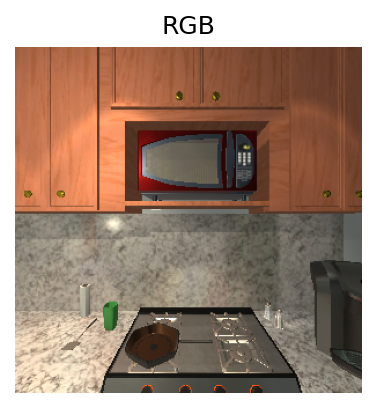

In [ ]:
# Visualize an example frame from environment.
plot_frames(controller.last_event)

# Visualizations

## Plot Frames

Visualize each frame and image modality available on an Event.

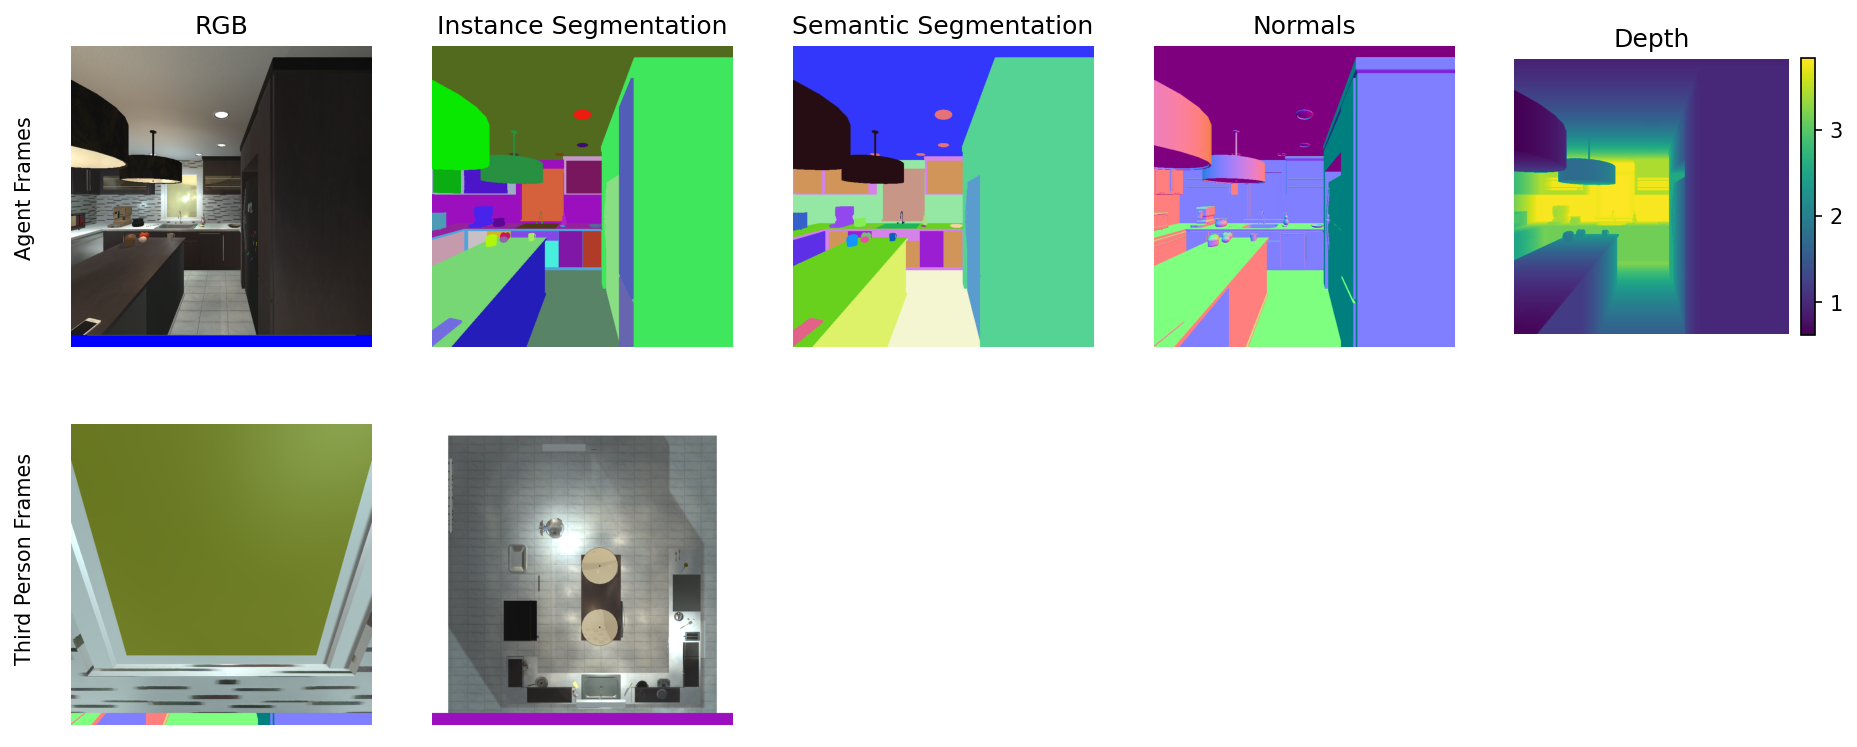

In [ ]:
renderDepthImage = True            #@param {type: "boolean"}
renderInstanceSegmentation = True  #@param {type: "boolean"}
renderSemanticSegmentation = True  #@param {type: "boolean"}
renderNormalsImage = True          #@param {type: "boolean"}

controller.reset(
    scene="FloorPlan2",
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=renderDepthImage,
    renderInstanceSegmentation=renderInstanceSegmentation,
    renderSemanticSegmentation=renderSemanticSegmentation,
    renderNormalsImage=renderNormalsImage
)

# adds a cameras from a third-person's point of view
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=0, y=1.55, z=-2.3),
    rotation=dict(x=20, y=0, z=0)
)

# adds an orthographic top-down image
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)

plot_frames(controller.last_event)

## Save Frames

Save the environment scenes for editing purpose.

In [ ]:
import os
import numpy as np
from controlnet_aux import HEDdetector
from controlnet.attention_store import StoreFeatures, EmptyFeatures
from controlnet.ControlNetPipeline import StableDiffusionControlNetImg2Img
import torch
from PIL import Image 
from controlnet.constants import PREPROCESSOR_DICT
import os

for scene in range(1, 420):
    scene_name = f"FloorPlan{scene}"
    controller.reset(
        scene=scene_name,
        width=512,
        height=512,
        renderDepthImage=True,
        renderNormalsImage=True,
        renderInstanceSegmentation=True,
        renderSemanticSegmentation=True
    )
    os.makedirs(f"scenes/{scene_name}")
    for i, _ in enumerate(range(360 // 5)):
        event = controller.step(action="RotateLeft", degrees=5)
        rgb = event.frame
        instance_segmentation = event.instance_segmentation_frame
        semantic_segmentation = event.semantic_segmentation_frame
        normals = event.normals_frame
        depth = event.depth_frame

        depth = (depth - np.min(depth))/(np.max(depth) - np.min(depth)) * 255

        
        Image.fromarray(rgb).save(f"scenes/{scene_name}/rgb_{i:06d}.png")
        Image.fromarray(instance_segmentation).save(f"scenes/{scene_name}/instance_seg_{i:06d}.png")
        Image.fromarray(semantic_segmentation).save(f"scenes/{scene_name}/semantic_seg_{i:06d}.png")
        Image.fromarray(normals).save(f"scenes/{scene_name}/normals_{i:06d}.png")
        Image.fromarray(depth).convert("RGB").save(f"scenes/{scene_name}/depth_{i:06d}.png")

# show_video(frames, fps=5)

## Side By Side Frames

Shows 2 image frames side-by-side. This is often nice to visualize the before and after results from an action.

In [ ]:
side_by_side(
    frame1=controller.last_event.frame,
    frame2=controller.step("RotateRight", degrees=30).frame,
    title="RotateRight Result"
)

## Overlay Frames

In [ ]:
objectId = next(obj["objectId"] for obj in controller.last_event.metadata['objects'] if obj['pickupable'])
print("Picking up " + objectId)

start_frame = controller.last_event.frame
pickup_frame = controller.step(
    action="PickupObject",
    objectId=objectId,
    forceAction=True
).frame

#@markdown `frame2_alpha` controls the opacity that the 2nd frame has, when blended over the 1st frame.
#@markdown Notice with a 0.75 opacity, the status's base appears see-throguh.

overlay(
    frame1=start_frame,
    frame2=pickup_frame,
    title="Pickup Object",
    frame2_alpha=0.75 #@param {type: "slider", min: 0.01, max: 0.99, step: 0.01}
)

## Augmentation of Scenes

In this section, we perform the augmentation to the existing floorplans. We use `ControlNet` with `lineart coarse` condition to augment the environment. To satisfy consistency, we apply extended attention, which concatenates all the previous frames in cross attention layer.

In [ ]:
# PATHS
prompts = ['colorful Picasso painting', 'aluminum indoor texture', 'pink indoor texture', 'wooden indoor texture', 'golden indoor texture']
cnt = 0
for floor_idx in range(1, 21):
        FLOOR_PATH = f'scenes/FloorPlan{floor_idx}/'
        scene_images = sorted(os.listdir(FLOOR_PATH))
        for idx, scene_image_path in enumerate(scene_images):
                
                if not scene_image_path.startswith('rgb') or idx % 5:
                        continue
                
                if cnt == 5:
                        cnt = 0
                        break

                IMAGE_PATH = FLOOR_PATH + scene_image_path
                SAVE_PATH = f'./edited_image_{FLOOR_PATH.split("/")[1]}_{scene_image_path.split("_")[-1]}'

                # Get the image
                image =  Image.open(IMAGE_PATH)

                preprocess_name = 'lineart_coarse'
                checkpoint = PREPROCESSOR_DICT[preprocess_name]

                device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
                device = torch.device(device_name)

                # Parameters
                params_dict = {
                        'image': image,
                        'width': 512,
                        'height': 512,
                        'batch_size': 1,
                        'batch_size_vae': 1,
                        'positive_prompts': prompts[floor_idx % 5],
                        'negative_prompts': '',
                        'num_inference_steps': 20,
                        'guidance_scale': 8.5,
                        'strength': 1.0,
                        'seed': 1,
                        'scheduler_type': 'ddim',
                        'controlnet_conditioning_scale': 1.0,
                        'controlnet_guidance_start': 0.0,
                        'controlnet_guidance_end': 1.0,
                        'processor': preprocess_name
                }

                CN = StableDiffusionControlNetImg2Img(device)

                hf_path = 'runwayml/stable-diffusion-v1-5'

                CN.init_models(checkpoint, hf_path)
                feature_store = StoreFeatures()
                # feature_store = EmptyFeatures()
                CN.set_flow_controller(feature_store)

                edited_image = CN(**params_dict)
                edited_image.save(SAVE_PATH)
                
                del CN
                torch.cuda.empty_cache()
                os.remove('controlnet/store_params.pt')
                cnt += 1

In [3]:
# Save in the GIF format
from PIL import Image
images = []
for i in range(4, 25, 5):
    path = f'/home/ubuntu/allenact/scenes/FloorPlan4/rgb_{str(i).zfill(6)}.png'
    images.extend([Image.open(path)])

images[0].save("orig_deneme.gif", save_all=True, append_images=images[1:], optimize=False, loop=100, duration=500)